<a href="https://colab.research.google.com/github/AtulBha/Underwriting---Default-Risk/blob/main/Default_Risk_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install phik

     |████████████████████████████████| 1.1MB 3.8MB/s 
     |████████████████████████████████| 27.4MB 132kB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=166766246a4599de864446c75efd83ecefb79e9153c6c4f21829b764b51ba0a6
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
Successfully built phik
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


# <a id=''> Background </a>

Underwriting: is the process of taking financial risk for a renumeration (fee). In this particular case we are concerend with the commercial banking industry; specifically studying credit risk.

# <a id=''> Business Problem </a>
A major problem lenders face is finding the right balance between opportunity and cost. Specifically, there are many borrowers who do not have a well established credit history, like students.

Without a well established credit history for an applicant, it becomes difficult to determine the true risk associate with individual. Another challange is decision turn-around time for calculating default risk for individuals that do have a well established credit history.

As such an acceptable solution will determine the applicants repayment capability including those with limited credit history with fast turn-around that benefits both the borrower and the lender.


# <a id=''> Constraints </a>

- Model Performance is preferred over interpretability
- Making the correct decision more important that latency
- The cost of approving loans to defaulters is higher than dissapproval to non-defaulters




In [ ]:
import pandas as pd
data_dir = "/content/drive/MyDrive/Colab Notebooks/"

train = pd.read_csv(data_dir + 'application_train.csv')
test = pd.read_csv(data_dir + 'application_test.csv')
bureau = pd.read_csv(data_dir + 'bureau.csv')
bureau_bal = pd.read_csv(data_dir + 'bureau_balance.csv')
credit_bal = pd.read_csv(data_dir + 'credit_card_balance.csv')
payments = pd.read_csv(data_dir + 'installments_payments.csv')
cash_bal = pd.read_csv(data_dir + 'POS_CASH_balance.csv')
prev_application = pd.read_csv(data_dir + 'previous_application.csv')

In [ ]:
train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import phik

import missingno as msno
from IPython.display import display

# <a id=''> Check for missing data</a>

In [ ]:
from IPython.display import display

def n_missing(df, top_n = 20):
  #total for each column
  total = train.isnull().sum()
  total = total[total != 0].sort_values(ascending = False)

  #missing proportion for each columnn
  percent = total/train.shape[0]*100

  missing_summary = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  print (f"Your selected dataframe has {str(df.shape[1])} columns.\n"
         f"There are {str(missing_summary.shape[0])} "
         "columns that have missing values.")
  display(missing_summary.head(top_n))
  return missing_summary

In [ ]:
missing_features = n_missing(train)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


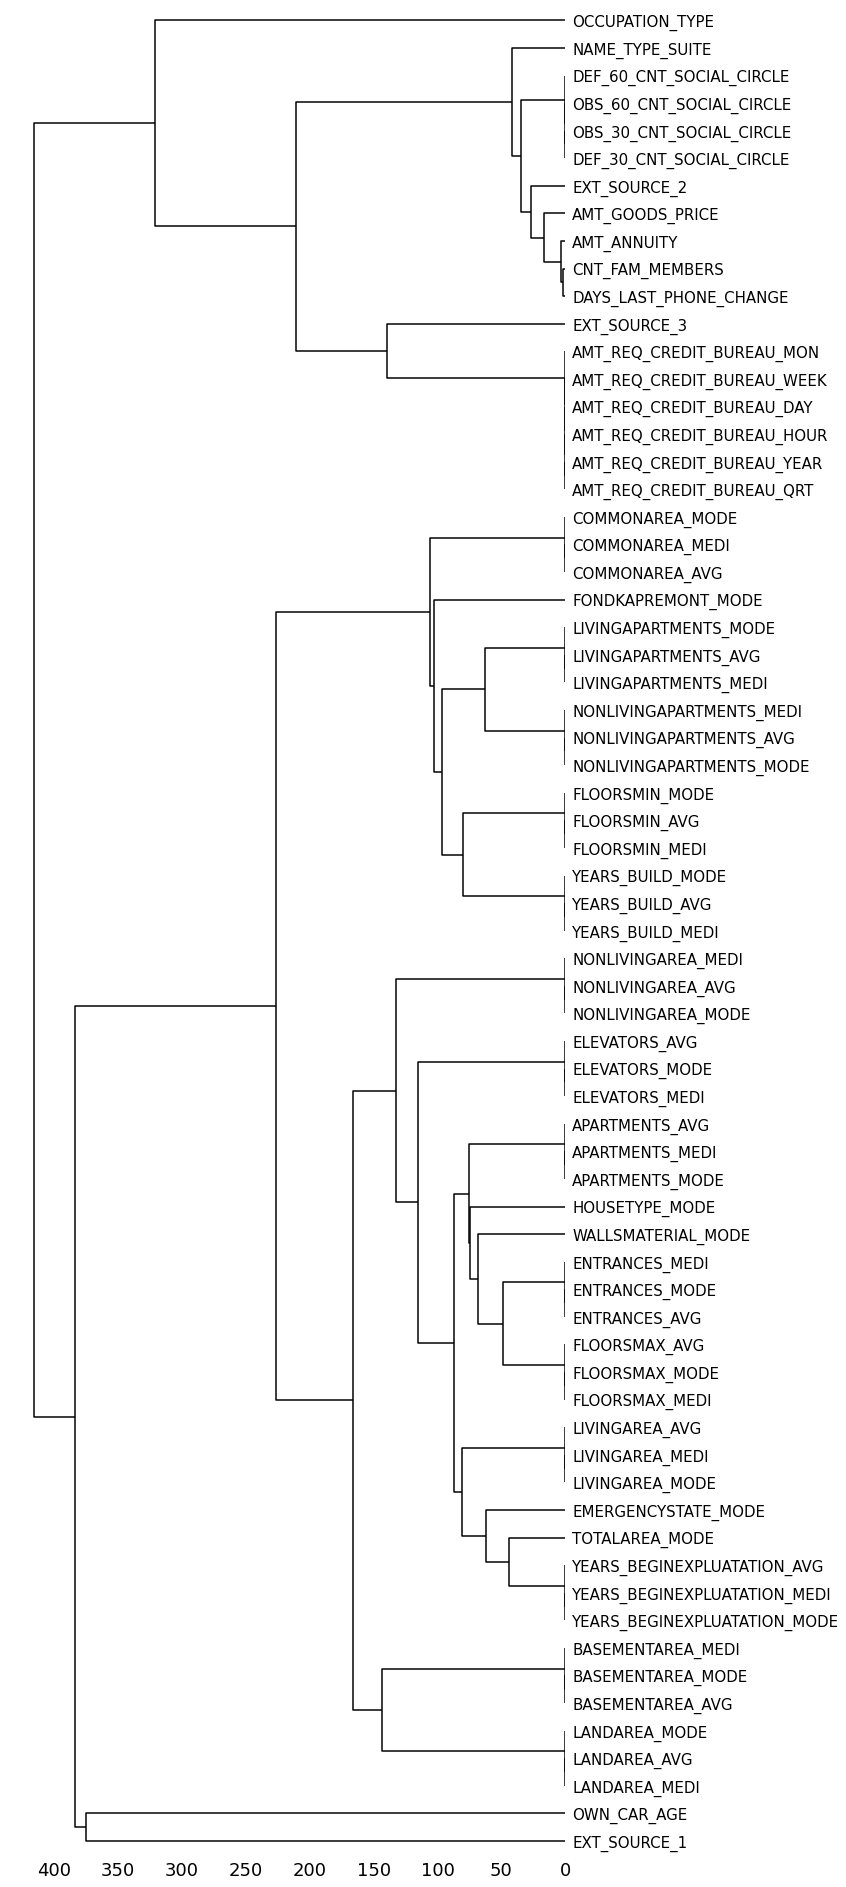

In [ ]:
msno.dendrogram(train[missing_features.index], figsize=(10,34), fontsize=15)

- Missing Values Dendogram is an excellent way to determine redundant variables

# <a id=''> True Variable Type Identifier</a>

In [ ]:
def determine_variable_types(df, object_columns = None, threshold = 5):
  '''
    Determine Categorical Features in a DataFrame
    
    Inputs:
        df: DataFrame
            The DataFrame from which to determine categorical columns
        object_columns: list <optional>
            Exclusive columns to treat as object columns
        threshold: int
            Drop columns that are above threhold value
    '''
  
  # Find Nominal variables that appear as numeric
  categorical_columns = set()
  columns_to_check = df.select_dtypes('number').columns.to_list()

  while columns_to_check:
    labels = set()
    column = columns_to_check.pop()
    for _, row in df[column].items():
      if not np.isnan(row):
        labels.add(row)
      if len(labels) > threshold:
        print(f'Bailing on {column}, Values Like: {labels}...')
        break
    else:
      categorical_columns.add(column)

  # Union above found variable with object_columns
  if object_columns is None:
    object_columns = df.select_dtypes(object).columns
    
  categorical_columns = set(categorical_columns).union(object_columns)

  col_dtypes = {'object': categorical_columns,
              'number': set(df.columns) - categorical_columns}

  return col_dtypes

In [ ]:
col_dtypes = determine_variable_types(train)

Bailing on AMT_REQ_CREDIT_BUREAU_YEAR, Values Like: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}...
Bailing on AMT_REQ_CREDIT_BUREAU_QRT, Values Like: {0.0, 1.0, 2.0, 3.0, 4.0, 8.0}...
Bailing on AMT_REQ_CREDIT_BUREAU_MON, Values Like: {0.0, 1.0, 2.0, 3.0, 5.0, 6.0}...
Bailing on AMT_REQ_CREDIT_BUREAU_WEEK, Values Like: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}...
Bailing on AMT_REQ_CREDIT_BUREAU_DAY, Values Like: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}...
Bailing on DAYS_LAST_PHONE_CHANGE, Values Like: {-828.0, -1106.0, -815.0, -1134.0, -617.0, -2536.0}...
Bailing on DEF_60_CNT_SOCIAL_CIRCLE, Values Like: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}...
Bailing on OBS_60_CNT_SOCIAL_CIRCLE, Values Like: {0.0, 1.0, 2.0, 4.0, 8.0, 10.0}...
Bailing on DEF_30_CNT_SOCIAL_CIRCLE, Values Like: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}...
Bailing on OBS_30_CNT_SOCIAL_CIRCLE, Values Like: {0.0, 1.0, 2.0, 4.0, 8.0, 10.0}...
Bailing on TOTALAREA_MODE, Values Like: {0.3811, 0.1417, 0.0714, 0.0238, 0.0149, 0.0612}...
Bailing on NONLIVINGAREA_MEDI, Values Li

# <a id=''>Phi-K/Pearson Correlation</a>

In [ ]:
import phik

def plot_phik_pearson(df, target_var: str, cols_types = dict(), figsize = (20, 15), tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    '''
    Function to Phi_k matrix for categorical features
    
    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        target_var: str
            Target (categorical variable)
        cols_types: dict <optional>
            Categorical and/or Numeric types and names
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''
    
    #first fetching only the categorical features
    if cols_types == {}:
      cols_types['object'] = set(df.select_dtypes(object).columns)
      cols_types['number'] = set(df.select_dtypes('number').columns)

    if 'object' in col_dtypes:
      categorical_columns = set(cols_types['object']).union({target_var})

      data_for_phik = df[categorical_columns].astype('object')
      phik_matrix = data_for_phik.phik_matrix()
      
      #print('-'*100)
      
      mask = np.triu(np.ones_like(phik_matrix, dtype=bool))
          
      plt.figure(figsize = figsize, tight_layout = tight_layout)
      sns.heatmap(phik_matrix, annot = False, mask = mask, linewidth = linewidth, cmap = cmap)
      plt.xticks(rotation = 90, fontsize = fontsize)
      #plt.yticks(rotation = 0, fontsize = fontsize)
      plt.title("Phi-K Correlation Heatmap for Categorical Features")
      plt.show()
      print("-"*100)

      if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")

        phik_df = phik_matrix[target_var].drop(target_var)
        phik_df = pd.DataFrame({'Column Name' : phik_df.index, 'Phik-Correlation' : phik_df.values})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100)

    if 'number' in cols_types:
      numerical_columns = set(cols_types['number']).union({target_var})

      # Compute the correlation matrix
      corr = df[numerical_columns].corr()

      # Generate a mask for the upper triangle
      mask = np.triu(np.ones_like(corr, dtype=bool))

      # Set up the matplotlib figure
      f, ax = plt.subplots(figsize=figsize)

      # Generate a custom diverging colormap
      sns.set_theme(style="white")
      cmap = sns.diverging_palette(230, 20, as_cmap=True)

      # Draw the heatmap with the mask and correct aspect ratio
      sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                  square=True, linewidths=.5, cbar_kws={"shrink": .5})
      #plt.xticks(rotation = 45, fontsize = fontsize)
      plt.title("Pearson Correlation Heatmap for Numeric Features")
      plt.show()
      
      print("-"*100)

      if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Numeric with highest values of Pearson Correlation value with Target Variable are:")

        target_corr_df = corr[target_var].drop(target_var)
        target_corr_df = pd.DataFrame({'Column Name' : target_corr_df.index, 'Pearson-Correlation' : target_corr_df.values})
        target_corr_df = target_corr_df.sort_values(by = 'Pearson-Correlation', key=lambda x: abs(x), ascending = False)
        display(target_corr_df.head(target_top_columns))
        print("-"*100)

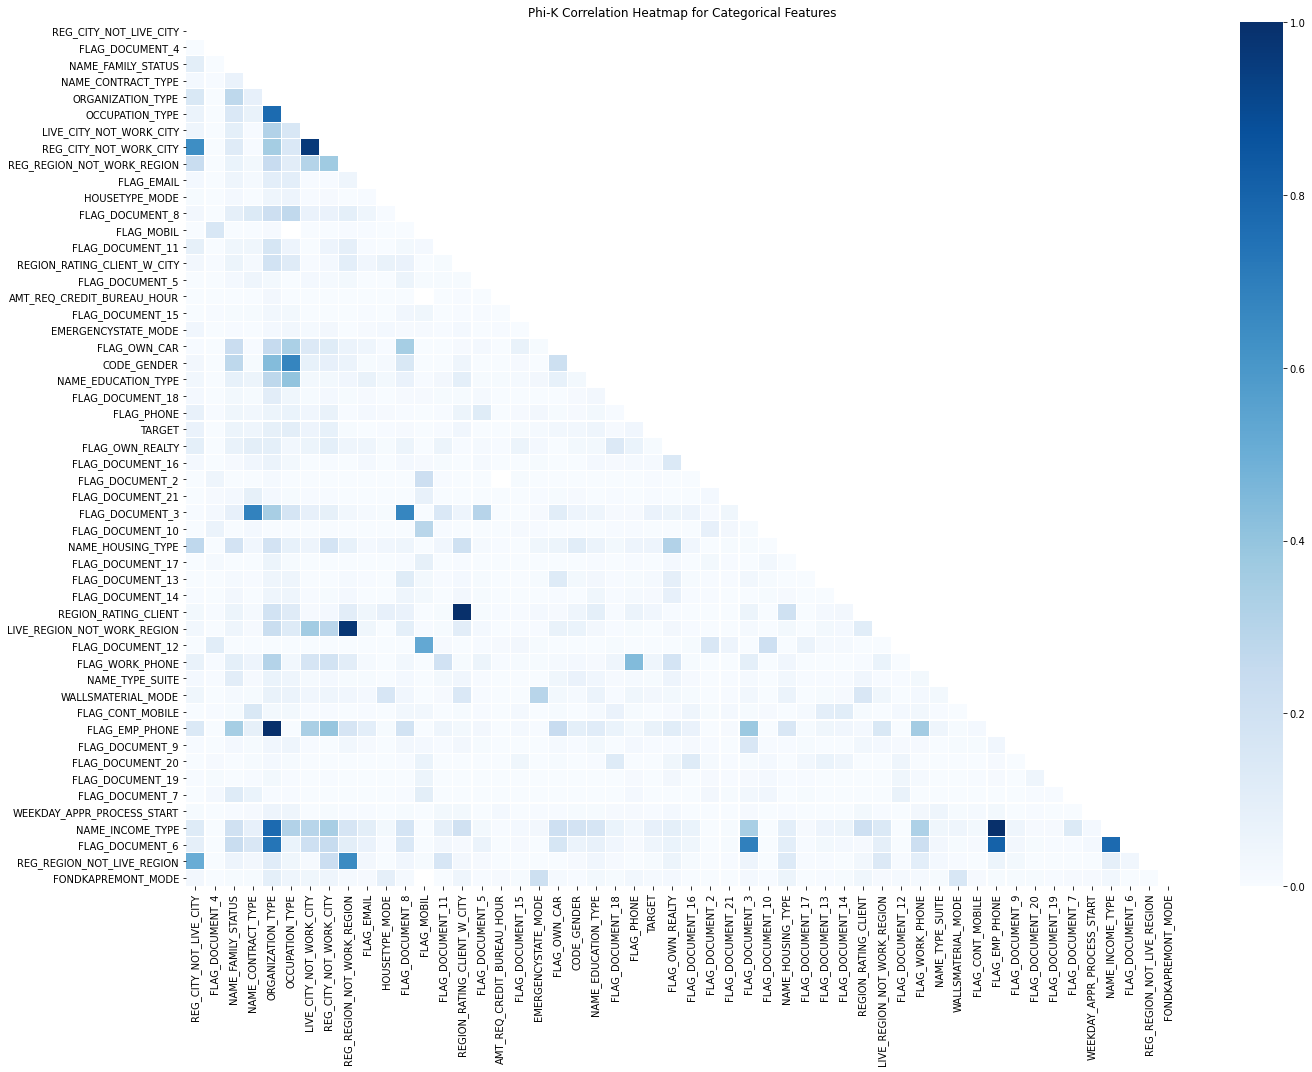

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
5,OCCUPATION_TYPE,0.102846
4,ORGANIZATION_TYPE,0.089164
47,NAME_INCOME_TYPE,0.084831
7,REG_CITY_NOT_WORK_CITY,0.079946
41,FLAG_EMP_PHONE,0.072087
0,REG_CITY_NOT_LIVE_CITY,0.069588
28,FLAG_DOCUMENT_3,0.069525
2,NAME_FAMILY_STATUS,0.056043
30,NAME_HOUSING_TYPE,0.051107
6,LIVE_CITY_NOT_WORK_CITY,0.050956


----------------------------------------------------------------------------------------------------


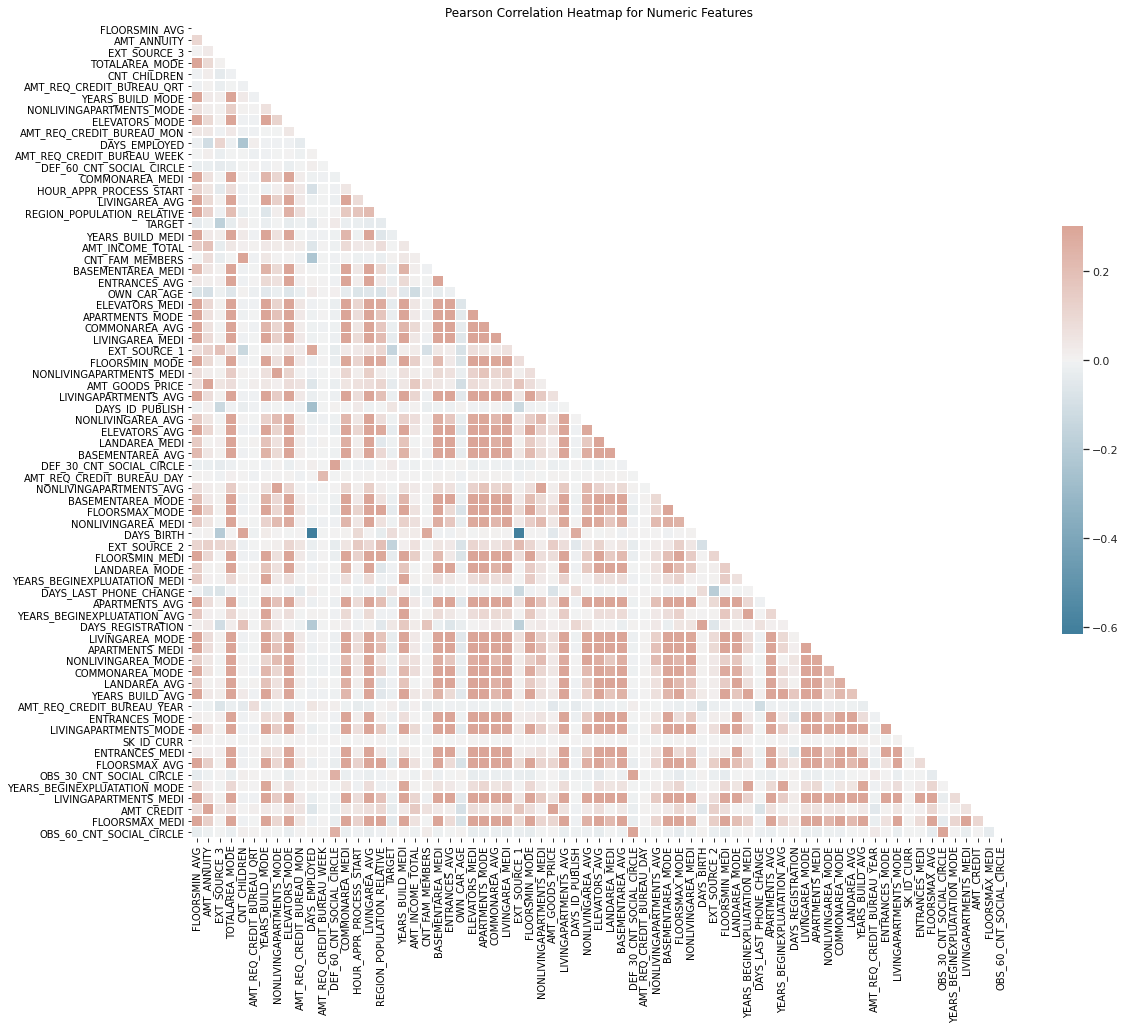

----------------------------------------------------------------------------------------------------
Numeric with highest values of Pearson Correlation value with Target Variable are:


,Column Name,Pearson-Correlation
2,EXT_SOURCE_3,-0.178919
44,EXT_SOURCE_2,-0.160472
27,EXT_SOURCE_1,-0.155317
43,DAYS_BIRTH,0.078239
48,DAYS_LAST_PHONE_CHANGE,0.055218
32,DAYS_ID_PUBLISH,0.051457
10,DAYS_EMPLOYED,-0.044932
63,FLOORSMAX_AVG,-0.044003
68,FLOORSMAX_MEDI,-0.043768
41,FLOORSMAX_MODE,-0.043226


----------------------------------------------------------------------------------------------------


In [ ]:
plot_phik_pearson(train, 'TARGET', col_dtypes)

# <a id=''>Distribution & Spread of Data</a>

### Check class Imbalance/distribution

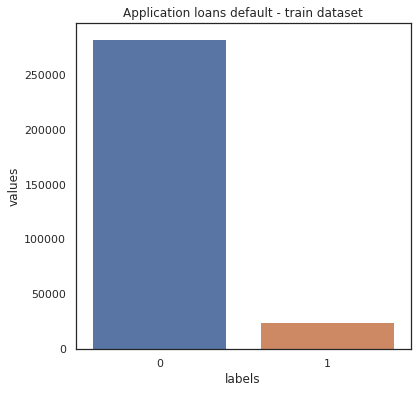

In [ ]:
#Distribution of Target Variable - relatively small number will default

temp = train.TARGET.value_counts()
temp_df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Application loans default - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=temp_df)
locs, labels = plt.xticks()
plt.show()

### Intra-Distribution (Cateogrical Variables) WRT Target Variable

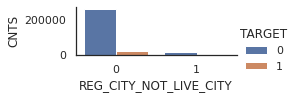

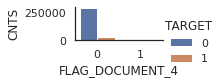

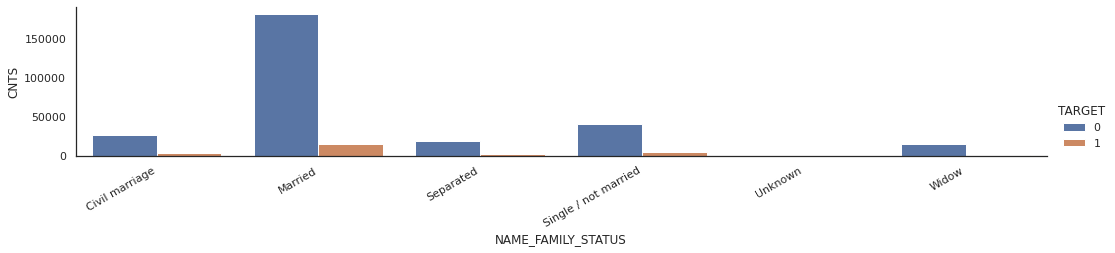

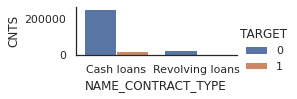

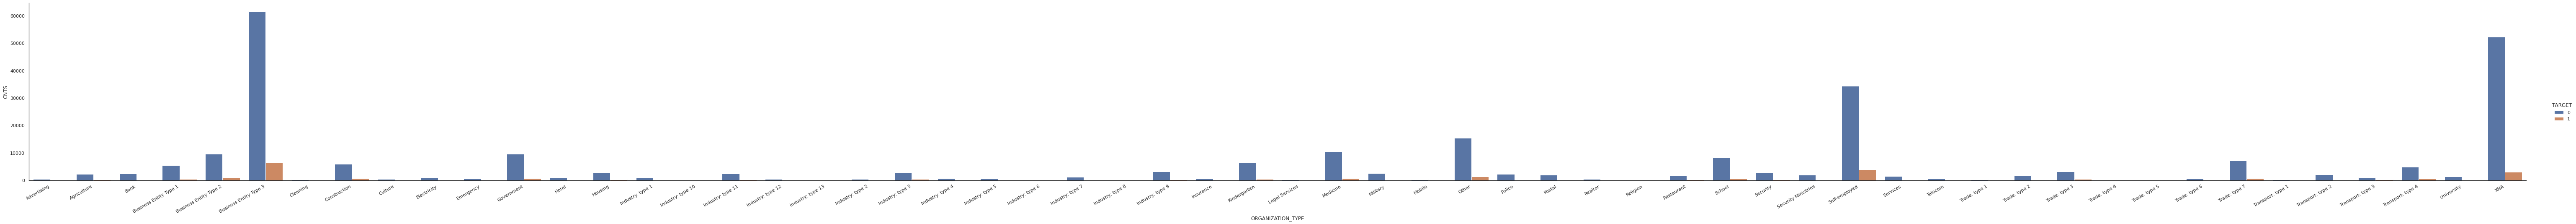

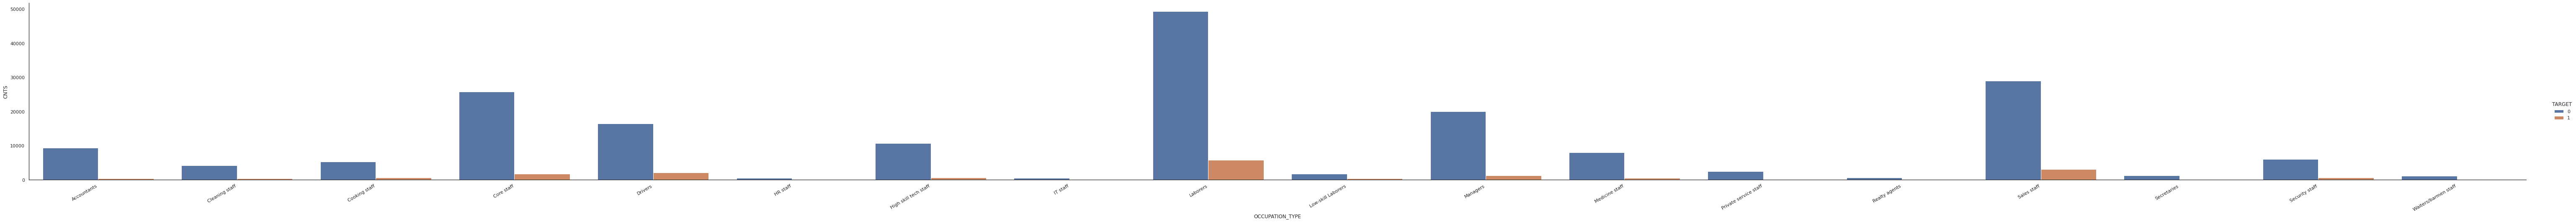

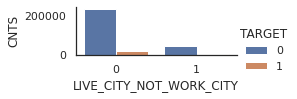

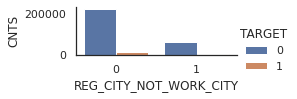

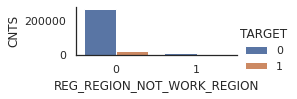

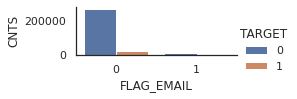

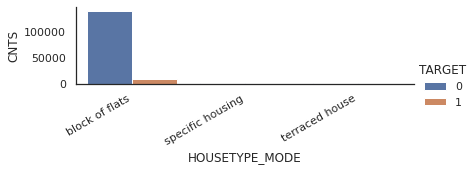

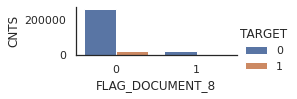

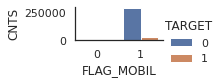

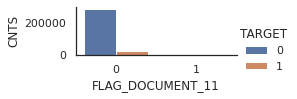

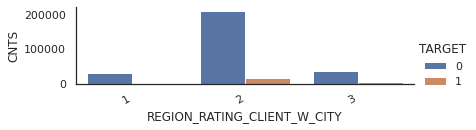

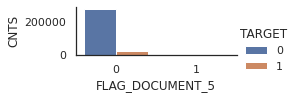

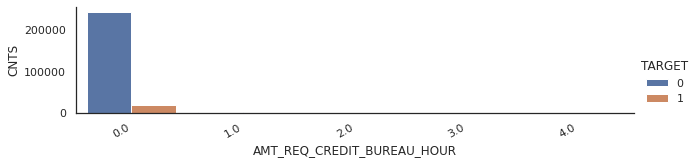

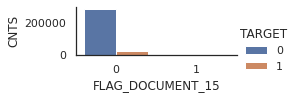

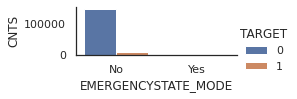

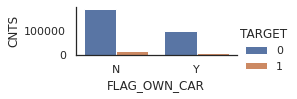

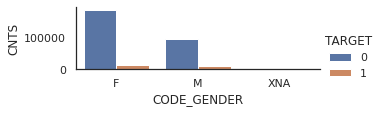

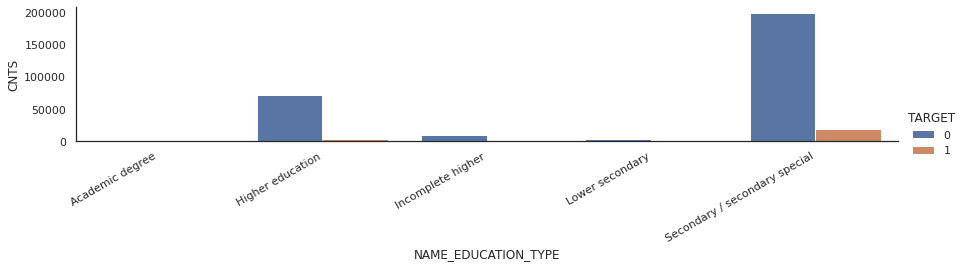

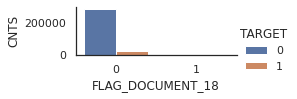

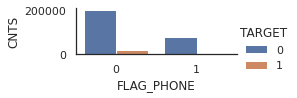

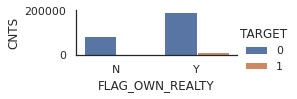

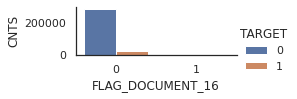

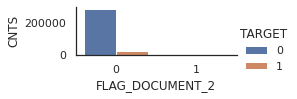

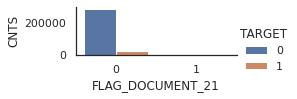

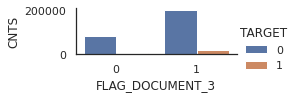

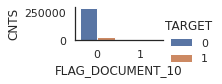

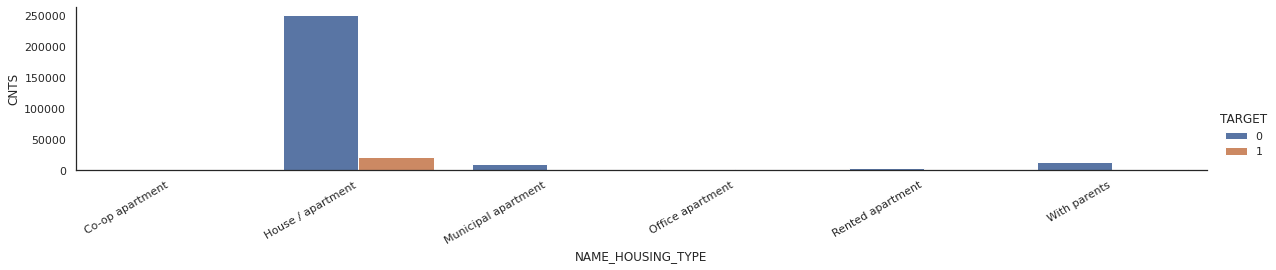

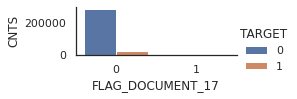

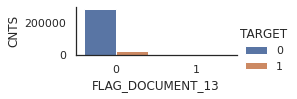

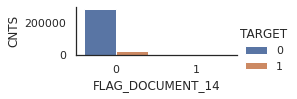

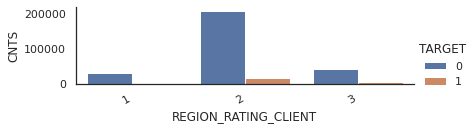

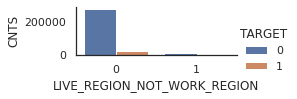

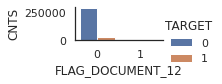

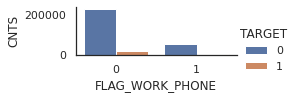

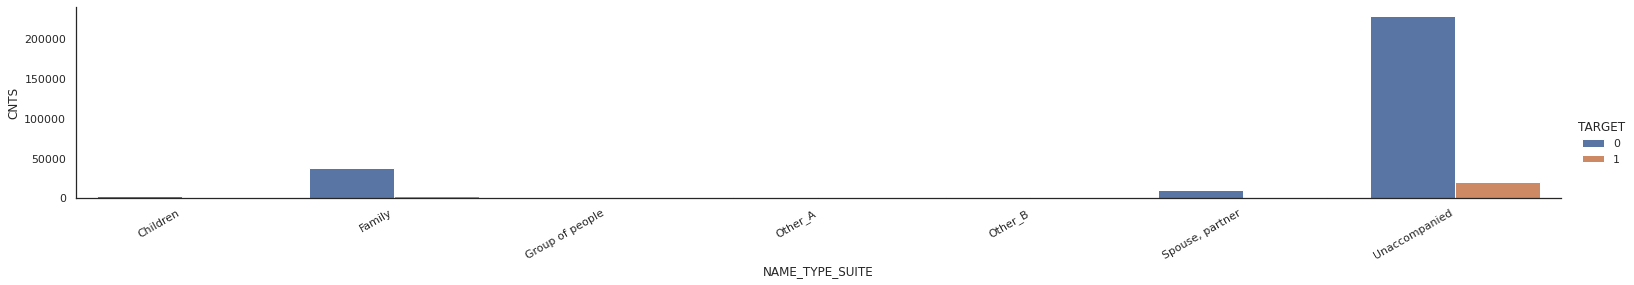

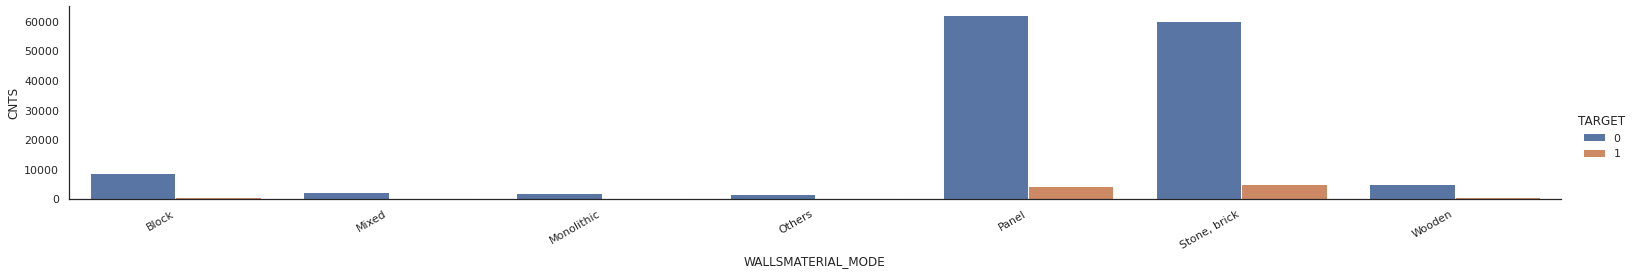

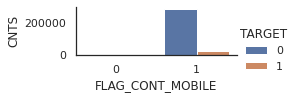

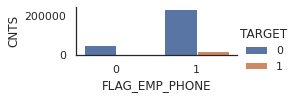

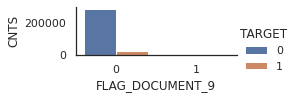

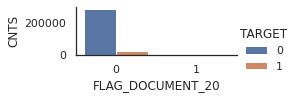

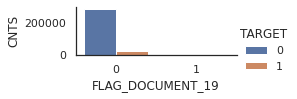

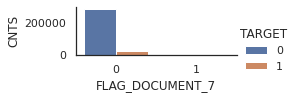

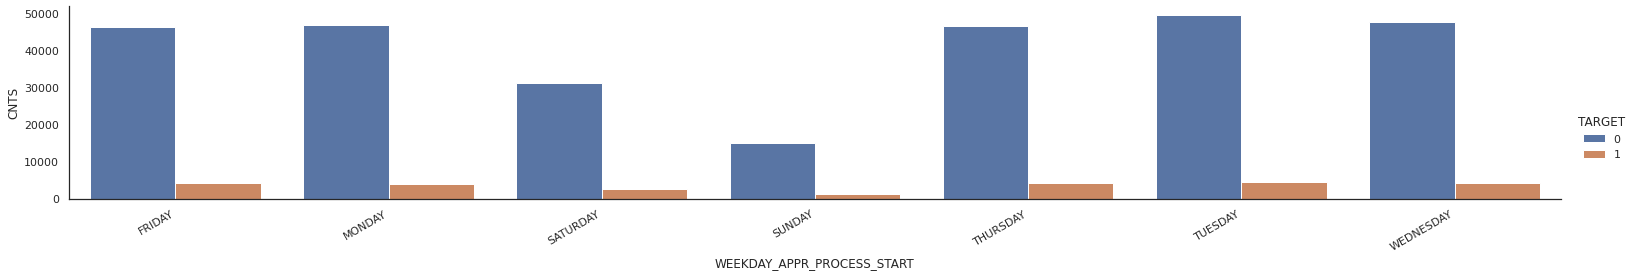

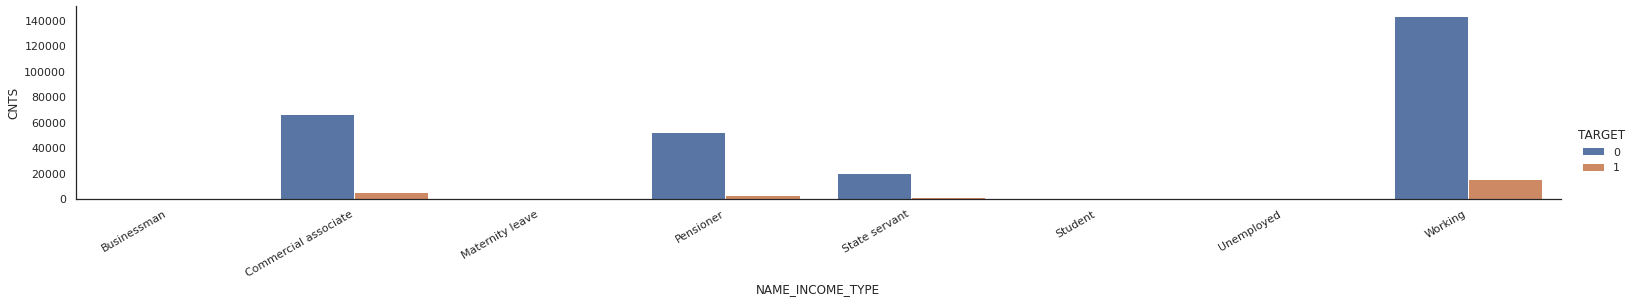

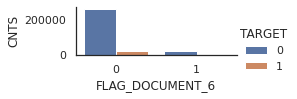

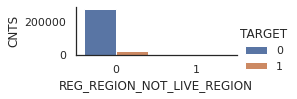

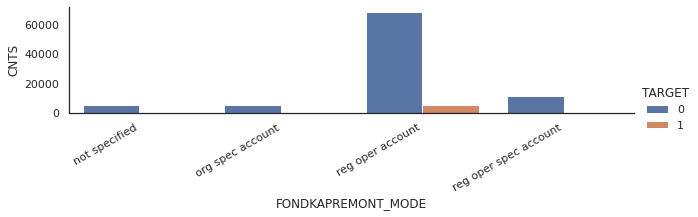

In [ ]:
target_var = 'TARGET'
plot_columns_cat = set(col_dtypes['object'])
plot_columns_cat.discard(target_var)

for column in plot_columns_cat:
  tmp_df = train.groupby([column, target_var])[[column]].count()
  tmp_df.rename(columns={column: 'CNTS'}, inplace=True)
  tmp_df.reset_index(inplace=True)
  
  sns.set_color_codes("pastel")
  size_factor = min(2^15, 1 + (tmp_df.shape[0] * 0.4))
  height = min(2^15, size_factor * 0.5)
  plot = sns.catplot(x=column, y='CNTS', hue=target_var, data=tmp_df, kind='bar', aspect=size_factor, height=height)
  if tmp_df.shape[0] > 5:
    plot.set_xticklabels(rotation=30, ha="right")
  plt.show()
  plt.close(plot.fig)

### Distribution of Continous Variables

In [ ]:
def plot_continous(df: pd.DataFrame, column: str, class_var: str, plots = {'PDF', 'CDF', 'box', 'violin'}, colors = ['red', 'black', 'green'], log_scale = False, figsize = (25,8)): 

  number_of_subplots = len(plots)
  plt.figure(figsize = figsize)
  colors_idx = 0
  sns.set_style('whitegrid')


  x = df[[class_var, column]].dropna().sort_values(by=column)

  for label, grp_df  in x.groupby(class_var): # group-level plots
    
    plt.subplots_adjust(wspace=0.25)

    if 'PDF' in plots:  
      plt.subplot(1, number_of_subplots, 1)  # https://www.w3schools.com/python/matplotlib_subplots.asp
      sns.distplot(grp_df[column], label=label, hist = False, color = colors[colors_idx])
      plt.xlabel(column)
      plt.ylabel('Probability Density')
      plt.legend(fontsize='medium')
      plt.title("Dist-Plot of {}".format(column))
      if log_scale:
        plt.xscale('log')
        plt.xlabel(f'{column} (log scale)')

    if 'CDF' in plots:
      # Percentile Rank takes a value and calculates its rank in a set of value
      # Percentile takes the percentile rank and computes the corresponding value
      # CDF is a functions that maps values to cumulative probabilities
      plt.subplot(1, number_of_subplots, min(number_of_subplots, 2))
      plt.plot(grp_df[column], grp_df[column].rank(pct=True, method='first'), color = colors[colors_idx], label = label)
      plt.xlabel(column)
      plt.ylabel('Probability')
      plt.title('CDF of {}'.format(column))
      plt.legend(fontsize = 'medium')

    colors_idx += 1


  if 'violin' in plots:
    plot_pos = ('CDF' in plots) * 1 + ('PDF' in plots) * 1 + 1
    plt.subplot(1, number_of_subplots, min(number_of_subplots, plot_pos))
    sns.violinplot(x=class_var, y=column, data=x)
    plt.title("Violin-Plot of {}".format(column))
    plt.yscale('log')
    plt.ylabel(f'{column} (log Scale)')

  if 'box' in plots:
    plt.subplot(1, number_of_subplots, number_of_subplots)
    sns.boxplot(x=class_var, y=column, data=x)
    plt.title("Box-Plot of {}".format(column))
    if log_scale:
      plt.yscale('log')
      plt.ylabel(f'{column} (log Scale)')
  

  plt.show()

In [ ]:
#outlier
train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True) # found in plot below, corrected and reran

In [ ]:
#continous_vars = col_dtypes['number']  # not all make sense and some need to be transformed
continous_vars_candidates = ['DAYS_EMPLOYED', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'AMT_ANNUITY', 
                             'AMT_CREDIT', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']
train_continous = pd.DataFrame(train[continous_vars_candidates])

train_continous['YEARS_EMPLOYED'] = round(abs(train_continous.DAYS_EMPLOYED / 365), 2)
train_continous['AGE'] = round(abs(train_continous.DAYS_BIRTH / 365), 2)
train_continous['BIRTH_EMPLOYED_PROP'] = train_continous['YEARS_EMPLOYED'] / train_continous['AGE']
train_continous['INCOME_CREDIT_PROP'] = train_continous['AMT_INCOME_TOTAL'] / train_continous['AMT_CREDIT']
train_continous['INCOME_PER_HOUSEHOLD'] = train_continous['AMT_INCOME_TOTAL'] / train_continous['CNT_FAM_MEMBERS']
train_continous['ANNUITY_INCOME_PROP'] = train_continous['AMT_ANNUITY'] / train_continous['AMT_INCOME_TOTAL']
train_continous['PAYMENT_RATE'] = train_continous['AMT_ANNUITY'] / train_continous['AMT_CREDIT']

train_continous.drop(columns=['DAYS_EMPLOYED', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL'], inplace=True)

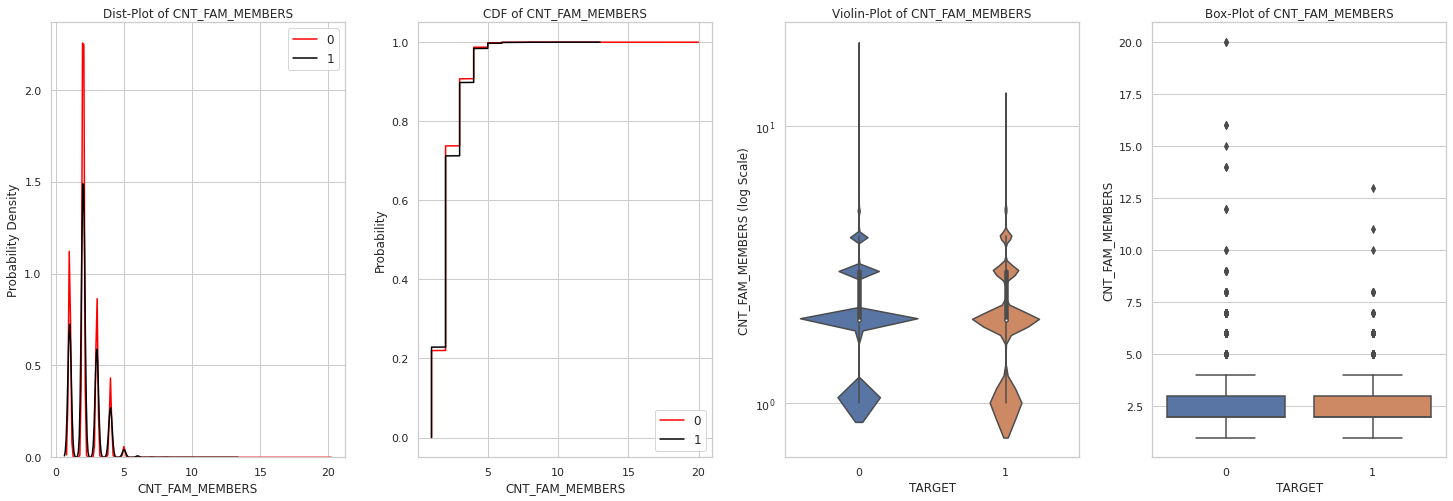

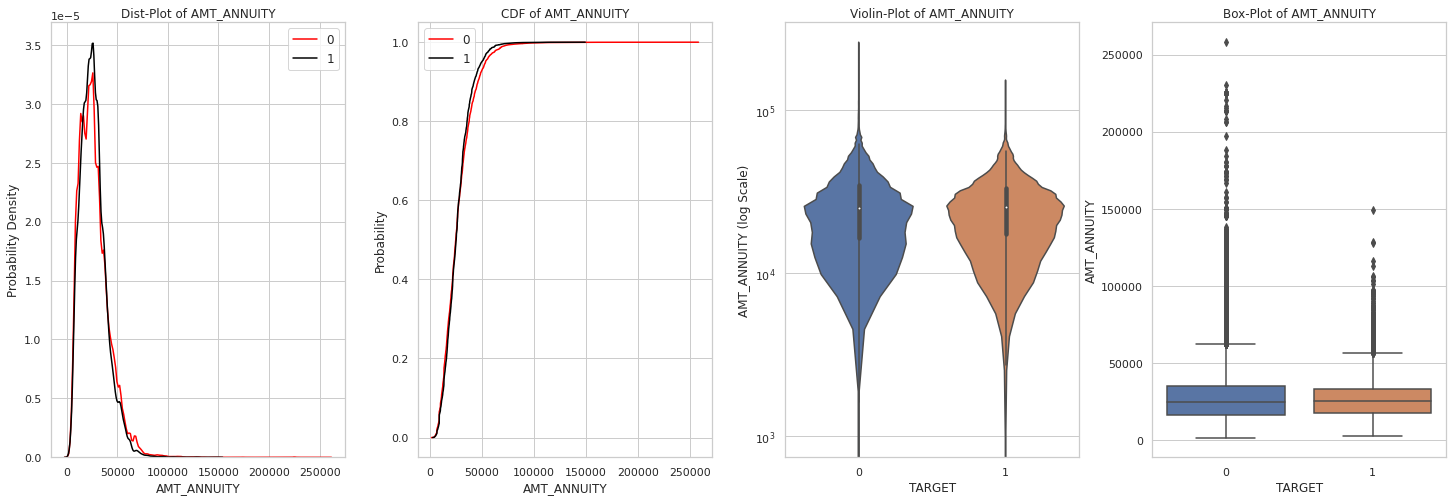

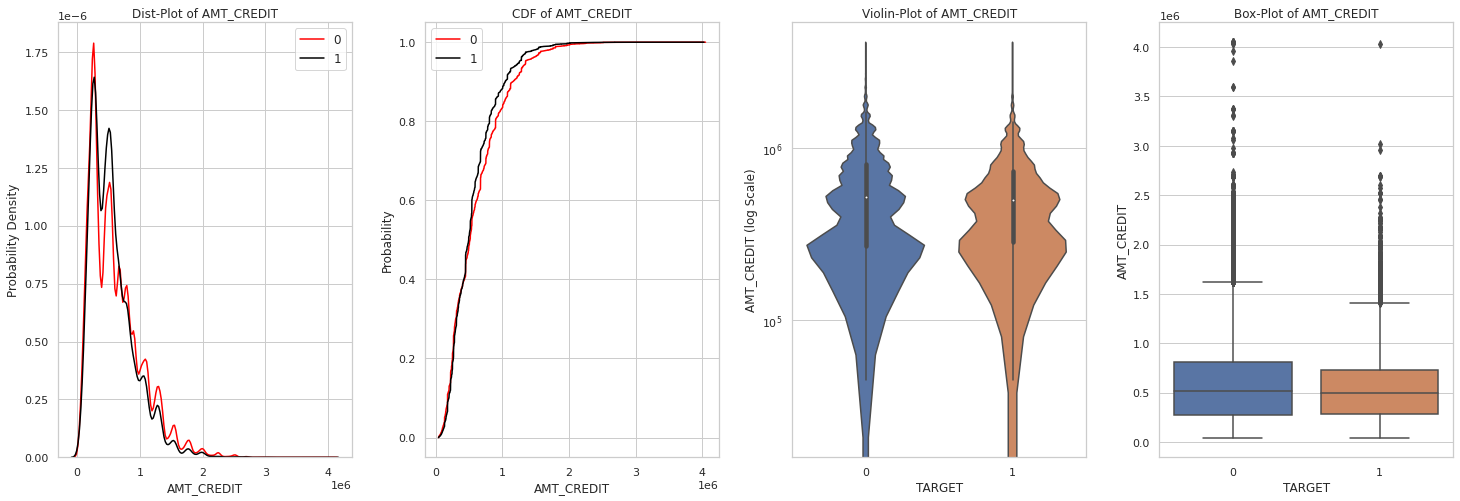

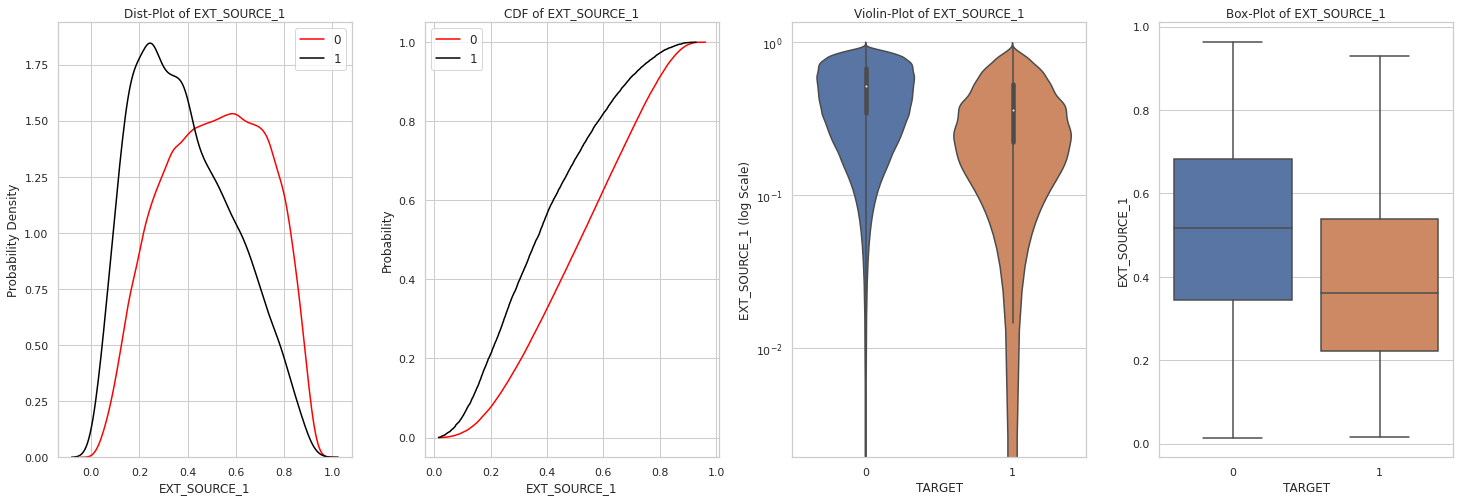

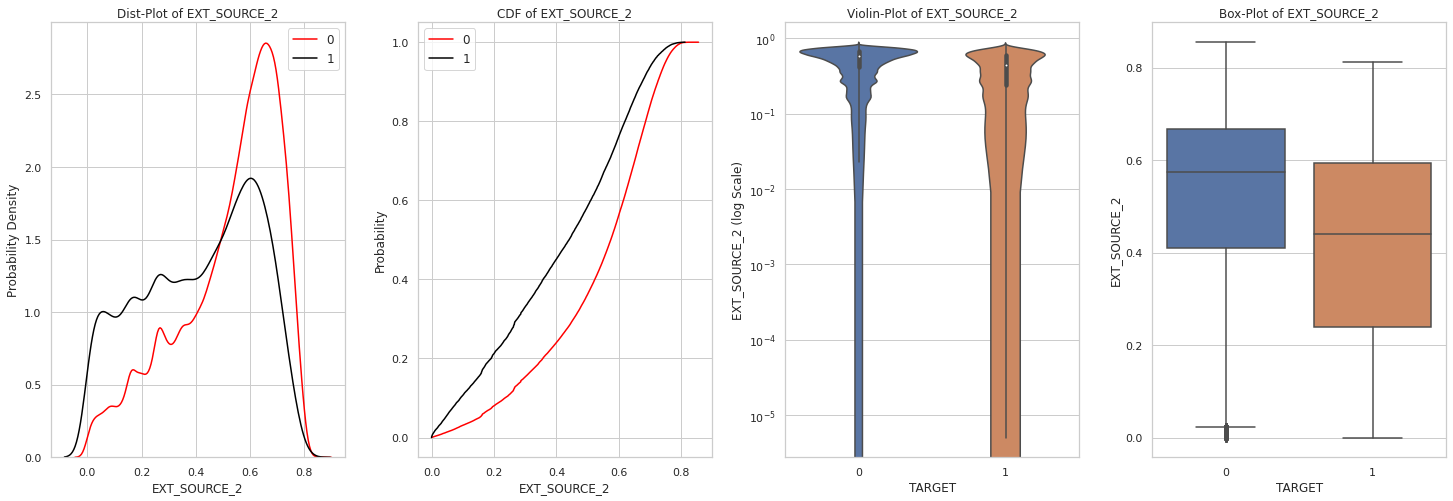

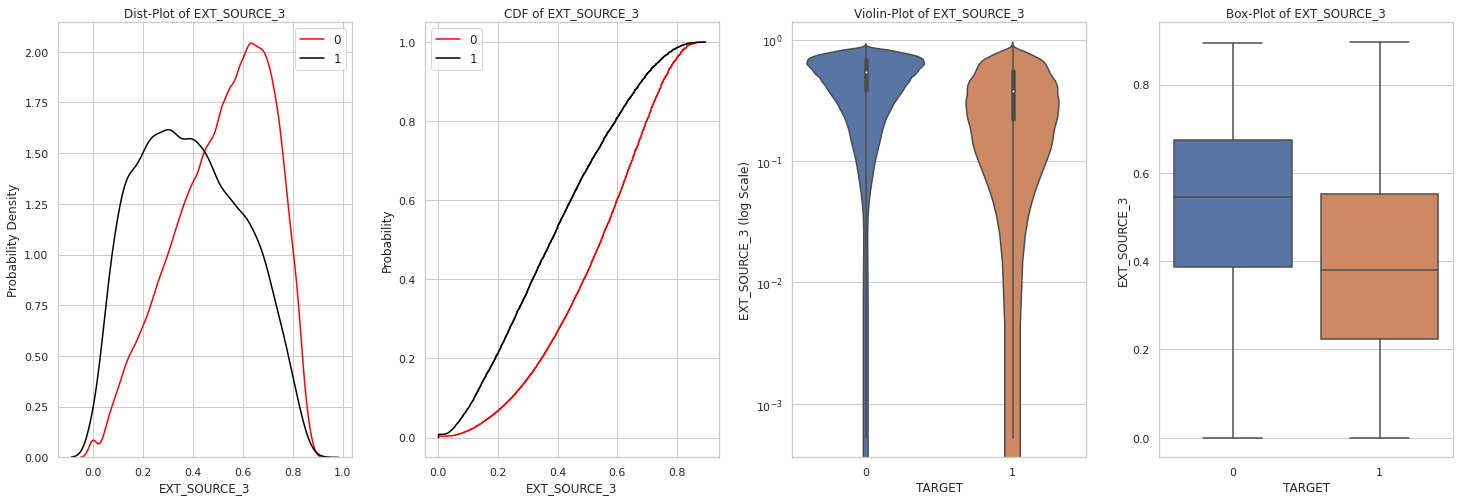

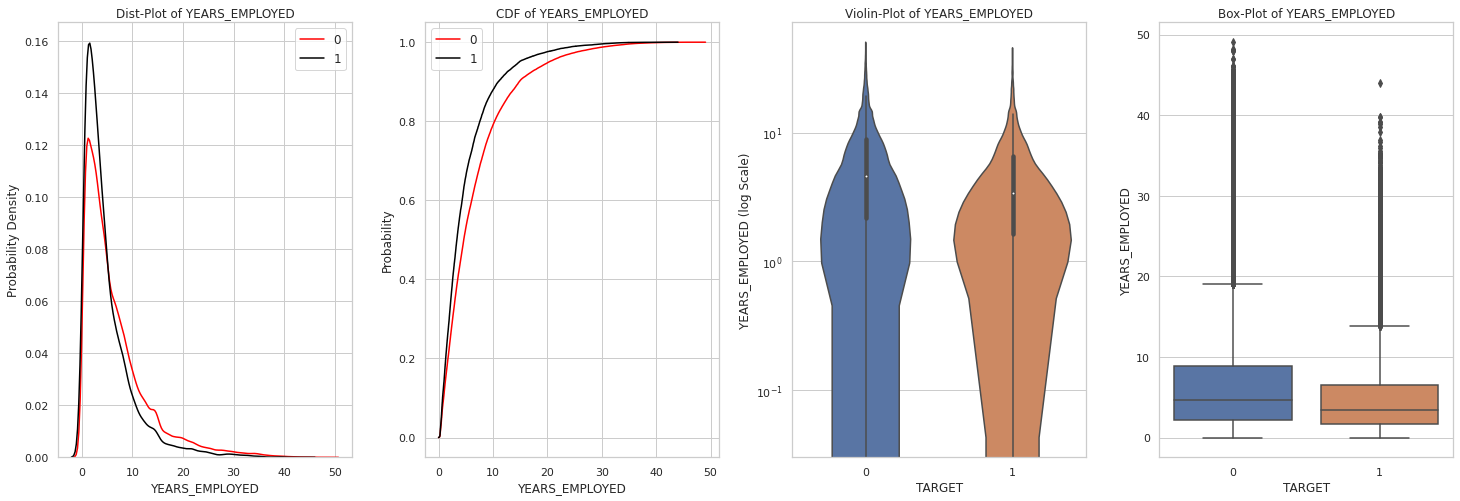

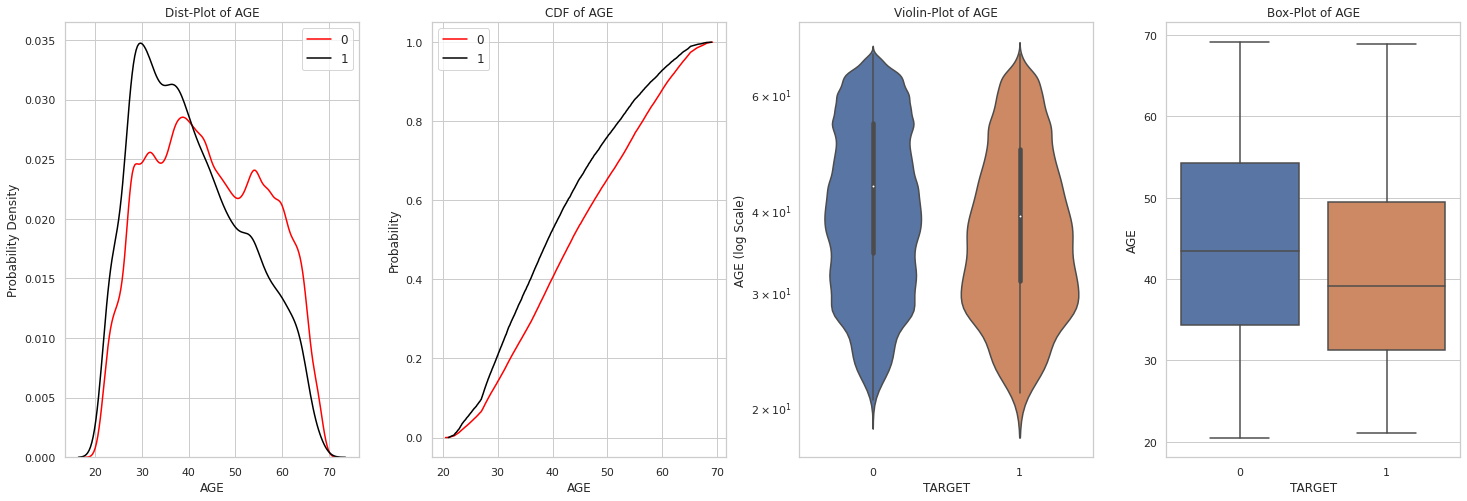

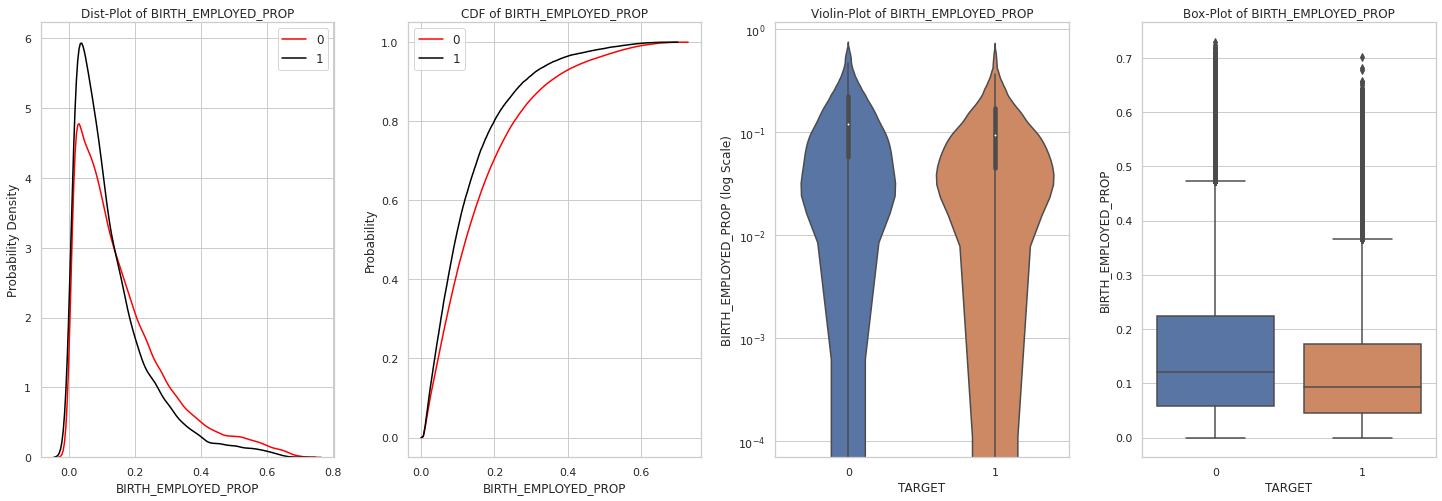

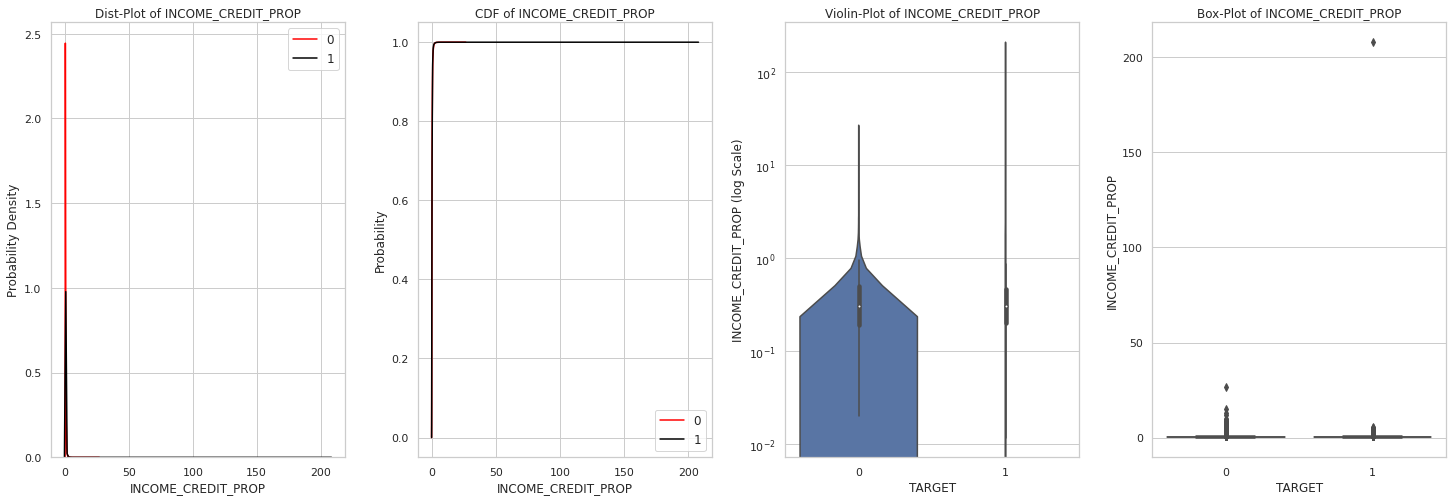

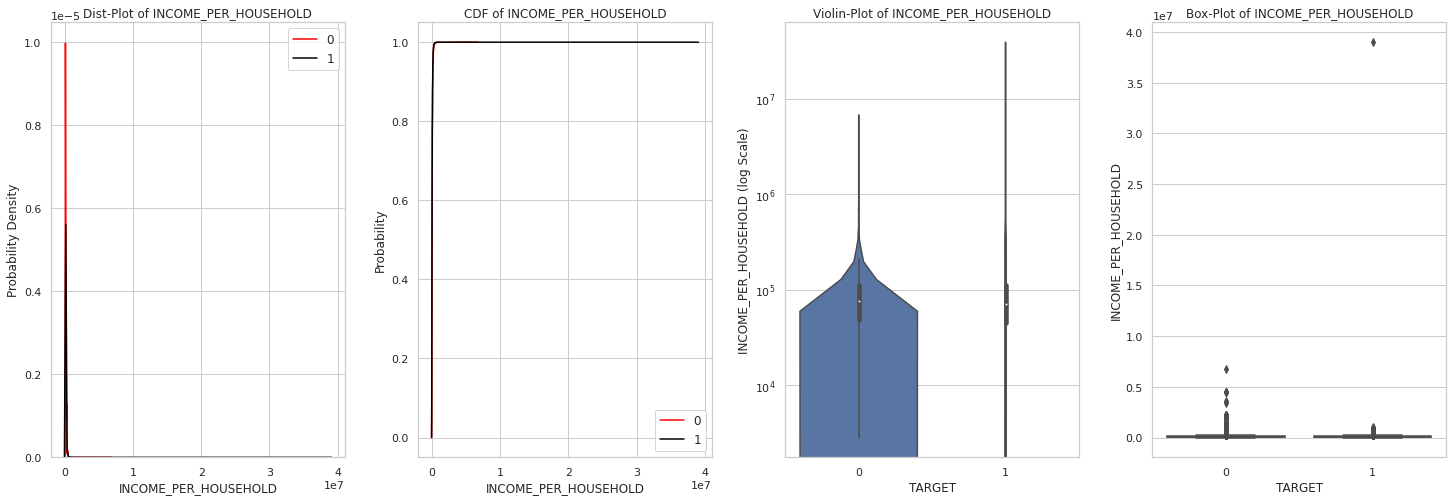

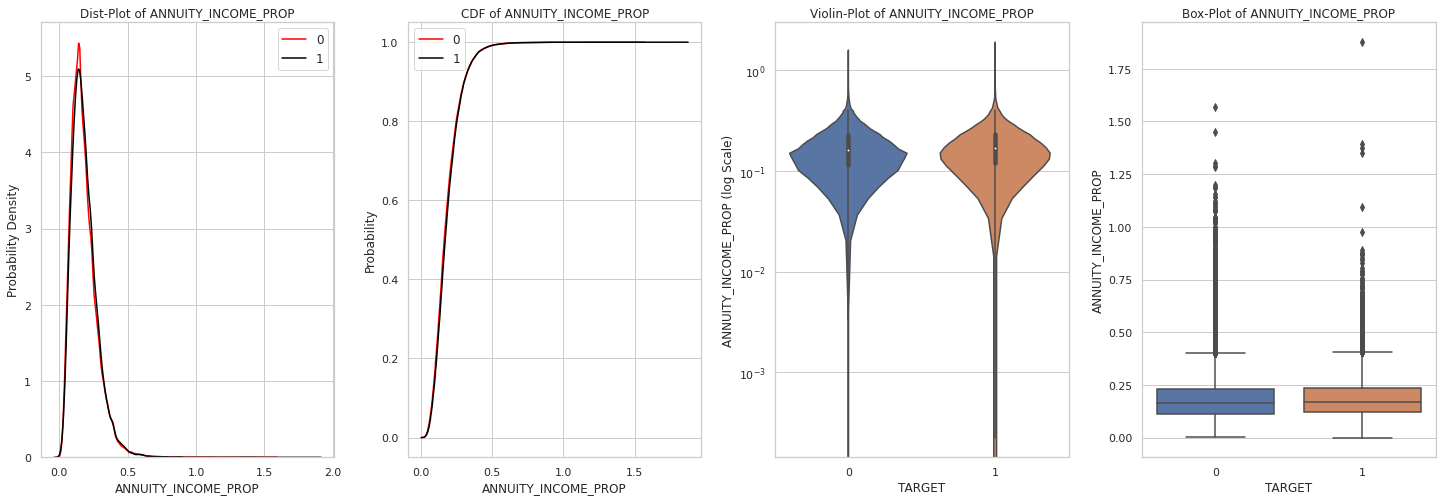

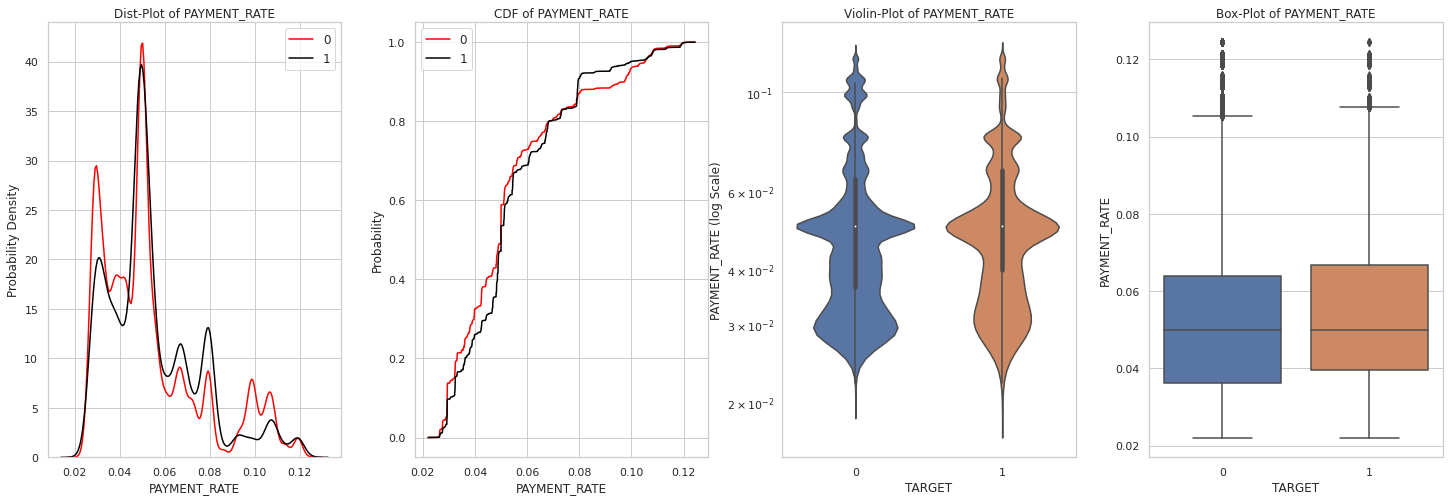

In [ ]:
import warnings
import matplotlib
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

target_var = 'TARGET'

for num_col in train_continous.columns.drop(target_var):
  plot_continous(train_continous, num_col, target_var)

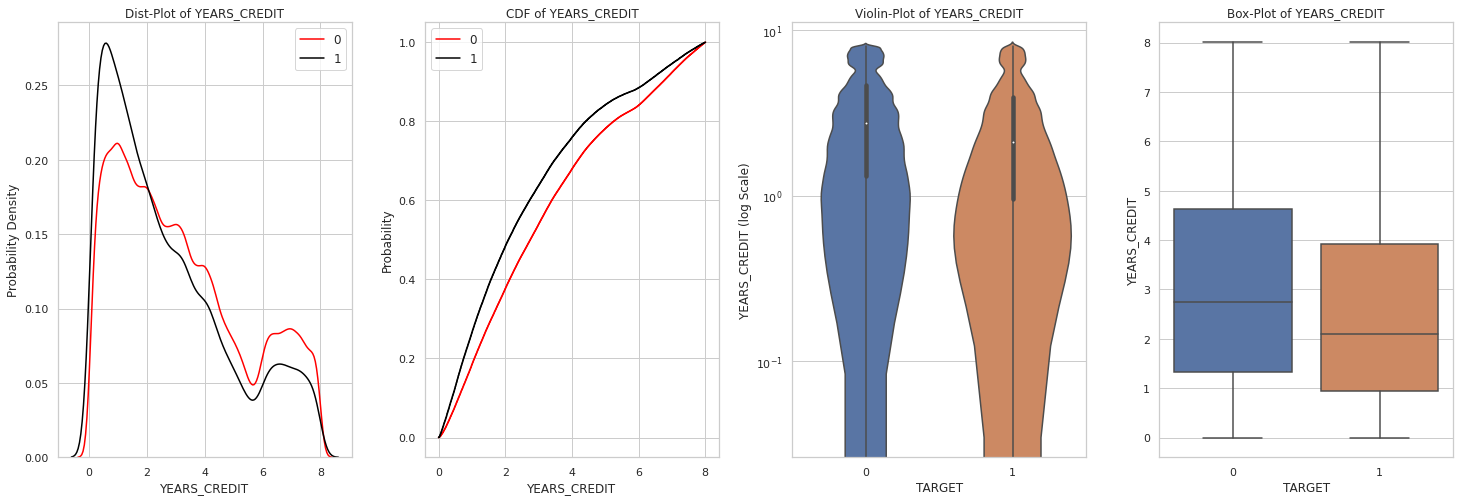

In [ ]:
bureau_continous = bureau[['SK_ID_CURR',
                           'DAYS_CREDIT']].merge(train[['SK_ID_CURR','TARGET']], on=['SK_ID_CURR'])
bureau_continous['YEARS_CREDIT'] = round(abs(bureau_continous.DAYS_CREDIT / 365), 2)
bureau_continous.drop(columns=['DAYS_CREDIT', 'SK_ID_CURR'], inplace=True)

plot_continous(bureau_continous, 'YEARS_CREDIT', 'TARGET')

#### Demography - exploring the relationships between economic, social, cultural, and biological processes influencing a population. These include:

- Gender
- Age
- Region
- DOB
- Education
- Occupation

Refrences:
https://en.wikipedia.org/wiki/Demography

In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=300, contamination= 0.01)
preds = clf.fit_predict(train_continous[['YEARS_EMPLOYED']].dropna())

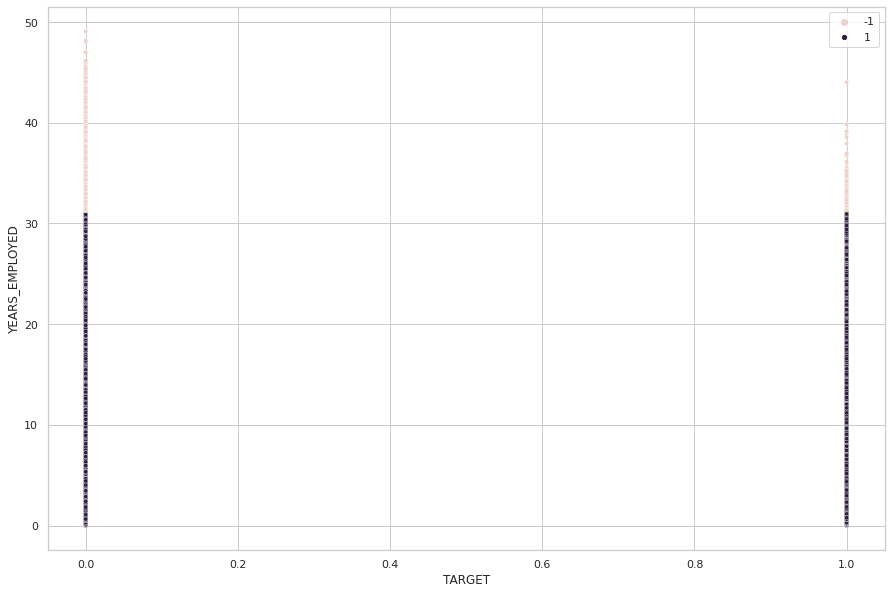

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=train_continous.dropna(subset=['YEARS_EMPLOYED']), x="TARGET", y="YEARS_EMPLOYED", hue=preds,
                     size=1)

In [ ]:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor